# Face Expression Detection

**Table of Contents**:

- [Libraries and Default Parameters](#Libraries-and-Default-Parameters)
- [Running GPU on Colab](#Running-GPU-on-Colab)
- [Getting the Data](#Getting-the-Data)
    - [Authenticating with Kaggle using kaggle.json](#Authenticating-with-Kaggle-using-kaggle.json)
    - [Face Expression Recognition Dataset](#Face-Expression-Recognition-Dataset)
    - [CK+ Dataset](#CK+-Dataset)
    - [Mixing the Datasets](#Mixing-the-Datasets)
- [Data Visualisation](#Data-Visualisation)
- [Image Augmentation](#Image-Augmentation)
- [Creating the Mode](#Creating-the-Model)
- [Compiling the Model](#Compiling-the-Model)
- [Callbacks](#Callbacks)
- [Training the Model](#Training-the-Model)
- [Assessing Performance](#Assessing-Performance)
    - [Learning Curves](#Learning-Curves)
    - [Making Predictions and Confusion Matrix](#Making-Predictions-and-Confusion-Matrix)
    - [Wrongly Classified Images](#Wrongly-Classified-Images)
- [Conclusions](#Conclusions)

<br>

## Libraries and Default Parameters

We start our notebook by importing all necessary libraries. 

In [1]:
import os
import glob
import random
import itertools

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

import keras
import tensorflow as tf

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import sklearn
from sklearn.metrics import confusion_matrix

from google.colab import files

Moreover, we will install and import [`watermark`](https://github.com/rasbt/watermark), an IPython magic extension that enables us to print version numbers and hardware information.

In [2]:
%%capture
!pip install watermark

In [3]:
import watermark
%load_ext watermark

# See version of system, Python, and libraries
%watermark -n -v -m -iv
print('sklearn   :', sklearn.__version__)

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.188+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

sklearn   : 0.0
numpy     : 1.21.6
seaborn   : 0.11.2
google    : 2.0.3
watermark : 2.3.0
matplotlib: 3.2.2
tensorflow: 2.8.0
IPython   : 5.5.0
pandas    : 1.3.5
keras     : 2.8.0

sklearn   : 1.0.2


Setting random seeds makes our work reproducible across different runs. However, when running on a GPU, some operations have non-deterministic outputs. As we read in the [official documentation]( https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development), '*this is due to the fact that GPUs run many operations in parallel, so the order of execution is not always guaranteed. Due to the limited precision of floats, even adding several numbers together may give slightly different results depending on the order in which you add them*'. Consequently, we should expect slightly different models after each run. 

In [4]:
seed_value = 0

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

To conclude this section, we will use `rcParams` to change some default components of Matplotlib’s default style. This is achieved by running:

`plt.rcParams[<param_name>] = value`

This practice allows us to customise figures to our aesthetic preferences, maintain the same style in all figures and reduce the amount of code in the main body of the notebook. Personally, I prefer setting some parameters at this stage and tweaking others when creating a figure.



In [5]:
font_size = 16

plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 1.25
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

plt.rcParams['xtick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['ytick.major.width'] = 1.2

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['tab:blue', 'tab:red', 'black']) 

For a complete list of `rcParams`, please visit the official webpage or run the command `plt.rcParams.keys()` in a cell.

<br>

## Running GPU on Colab

To ensure that GPU is running on this Colab notebook, we can follow the steps below:

1. Colab Menu: Select "Runtime"
2. "Change runtime type"
3. For "Hardware Accelerator", select "GPU"
4. Save

In [6]:
# Confirm that GPU is running
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

<br>

## Getting the Data

### Authenticating with Kaggle using kaggle.json

To retrieve the datasets, we need navigate to [Kaggle](https://www.kaggle.com) and sign in to our account. Then, we go to the [Account tab of our user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing our API credentials.

Finally, we need to run the cell below to upload kaggle.json to our Colab runtime.

In [8]:
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'\nUser uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
  
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json

User uploaded file "kaggle.json" with length 66 bytes


Once authentication is complete, we can proceed with downloading the data.

<br>

### Face Expression Recognition Dataset

The first dataset, available in this [link](https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset), will be referred to as ‘FER’ from this point onwards.

In [9]:
!kaggle datasets download jonathanoheix/face-expression-recognition-dataset

 82% 99.0M/121M [00:00<00:00, 223MB/s]
100% 121M/121M [00:00<00:00, 213MB/s] 


Notice that the contents of the dataset are downloaded as a zip file. Therefore, we need to run an unzip command to extract them. We use the `%% capture` at the beginning of the cell to suppress it's output ([Source]( https://stackoverflow.com/questions/56727370/how-to-suppress-output-in-google-colaboratory-cell-which-executes-a-command-line)).

In [10]:
%%capture
!unzip face-expression-recognition-dataset.zip

After this process is complete, we can delete the zip file (along with the duplicate data folder that is created). 

In [11]:
!rm /content/face-expression-recognition-dataset.zip
%rm -rf /content/images/images

<br>

### CK+ Dataset

In [12]:
!kaggle datasets download shawon10/ckplus

  0% 0.00/3.63M [00:00<?, ?B/s]
100% 3.63M/3.63M [00:00<00:00, 56.5MB/s]


In [13]:
%%capture
!unzip ckplus.zip

In [14]:
!rm /content/ckplus.zip
%rm -rf /content/ck

<br>

### Mixing the Datasets

Finally, we merge the two datasets by moving all images from the CK+48 directory to the FER directory based on their emotion.

In [15]:
!mv "/content/CK+48/anger"/* "/content/images/train/angry"
!mv "/content/CK+48/disgust"/* "/content/images/train/disgust"
!mv "/content/CK+48/fear"/* "/content/images/train/fear"
!mv "/content/CK+48/happy"/* "/content/images/train/happy"
!mv "/content/CK+48/sadness"/* "/content/images/train/sad"
!mv "/content/CK+48/surprise"/* "/content/images/train/surprise"

<br>

## Data Visualisation

In [16]:
base_path = r'/content/images/'

In [17]:
emotions_list = os.listdir(base_path + 'train/')
emotions_list = sorted(emotions_list)

print('Emotions:\n', *emotions_list, sep='\n  ')

Emotions:

  angry
  disgust
  fear
  happy
  neutral
  sad
  surprise


The data contain images depicting seven different emotions (facial expressions). We will save this number in a new variable called `num_classes`. This variable will be important when adding the last layer to our Neural Network.

In [18]:
num_classes = len(emotions_list)
print('Number of classes: ', num_classes)

Number of classes:  7


Let’s visualise five random images for each emotion. We know that images are normalised to 48x48 pixels in grayscale, so we set the `img_width`, `img_height`, and `img_depth` parameters appropriately (i.e. to 48, 48, and 1, respectively).

In [19]:
img_depth = 1
img_width, img_height = 48, 48

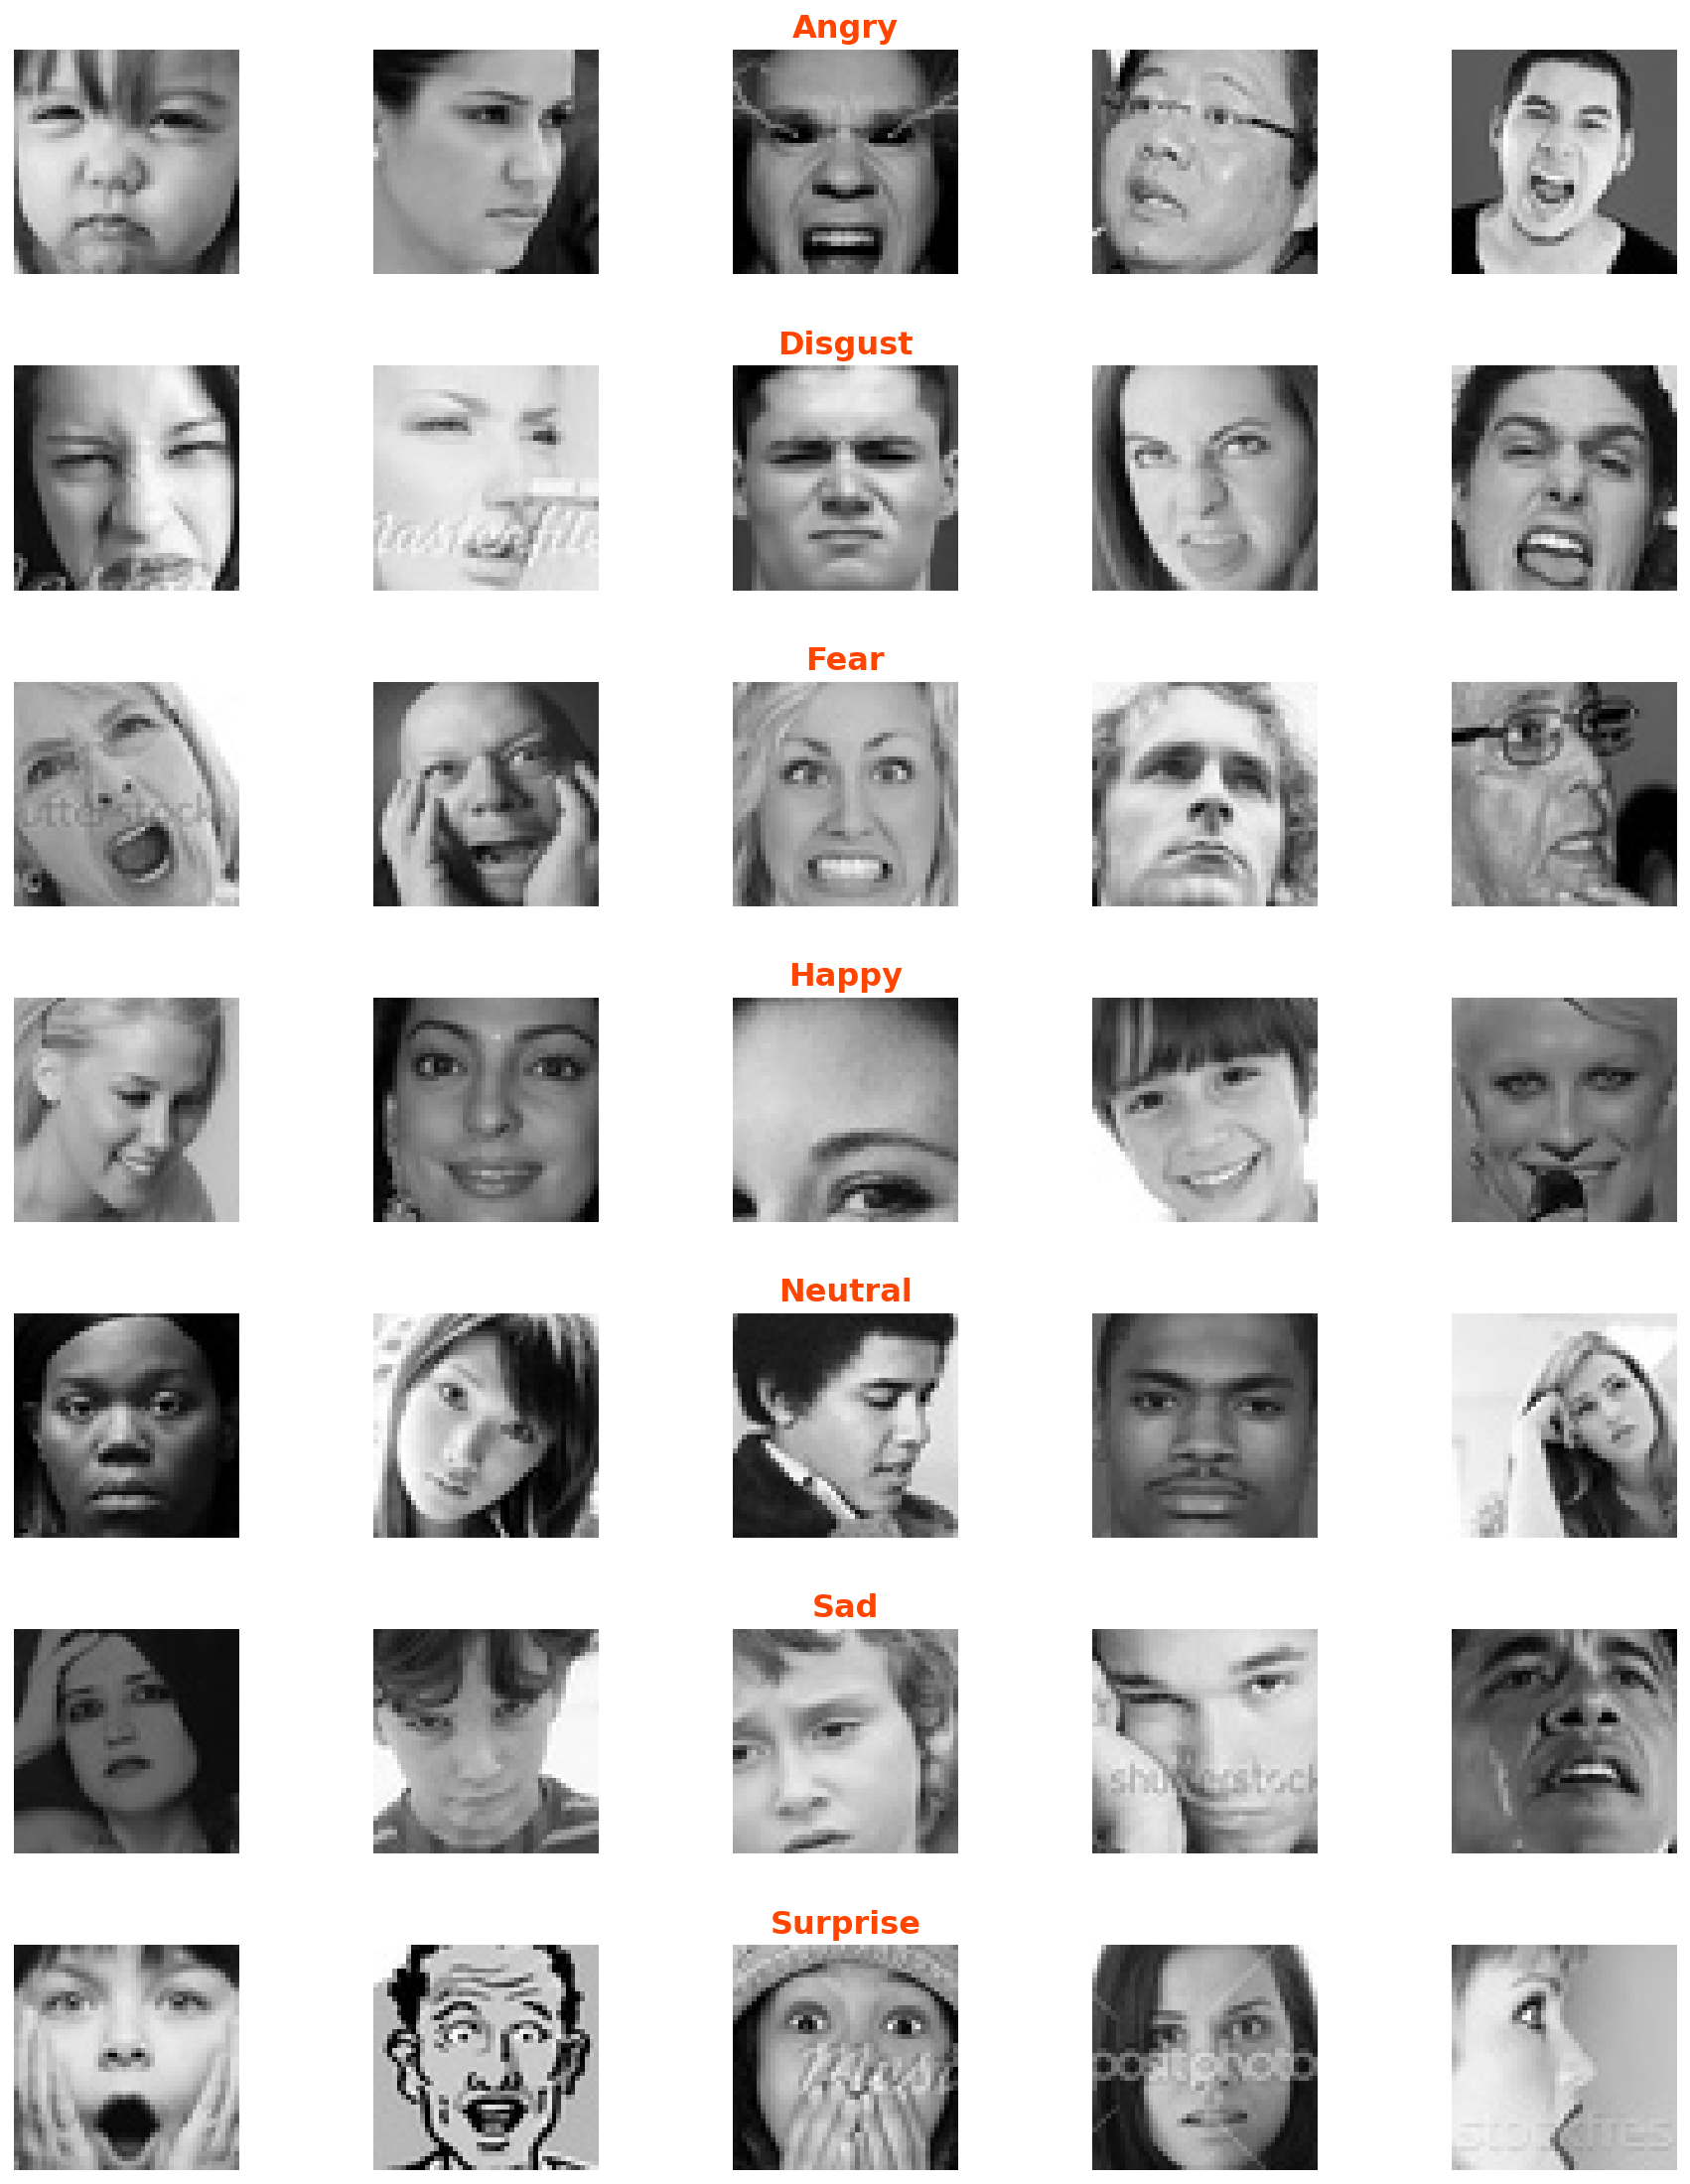

In [20]:
fig = plt.figure(0, figsize=(15, 20))

index = 1
for emotion in emotions_list:
    path = base_path + f'train/{emotion}'
    file_numbers = os.listdir(path)
    random_files = np.random.choice(file_numbers, size=5, replace=False)

    for i, random_file in enumerate(random_files):
        img = load_img(path=base_path + f'train/{emotion}/{random_file}',
                       target_size=(img_width, img_height))

        plt.subplot(7, 5, index)

        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if i == 2: plt.title(emotion.title(), color='orangered', weight='bold')
        index += 1

fig.subplots_adjust(wspace=0.6)
plt.show()

We can also extract the total number of files/images in the train and validation folders.

In [21]:
print('Number of images in folders:')
print('     Train: ', len(glob.glob("/content/images/train/*/*")))
print('Validation: ', len(glob.glob("/content/images/validation/*/*")))

Number of images in folders:
     Train:  29748
Validation:  7066


Also, it is always necessary to check if there is a class imbalance in the data. 

In [22]:
path = base_path + 'train/'
num_imgs = [len(os.listdir(path + f'{emotion}/')) for emotion in emotions_list]

df = pd.DataFrame({
    'Emotion': [emotion.title() for emotion in emotions_list],
    'Count': num_imgs
})
df.sort_values(by='Count', ascending=False, inplace=True)

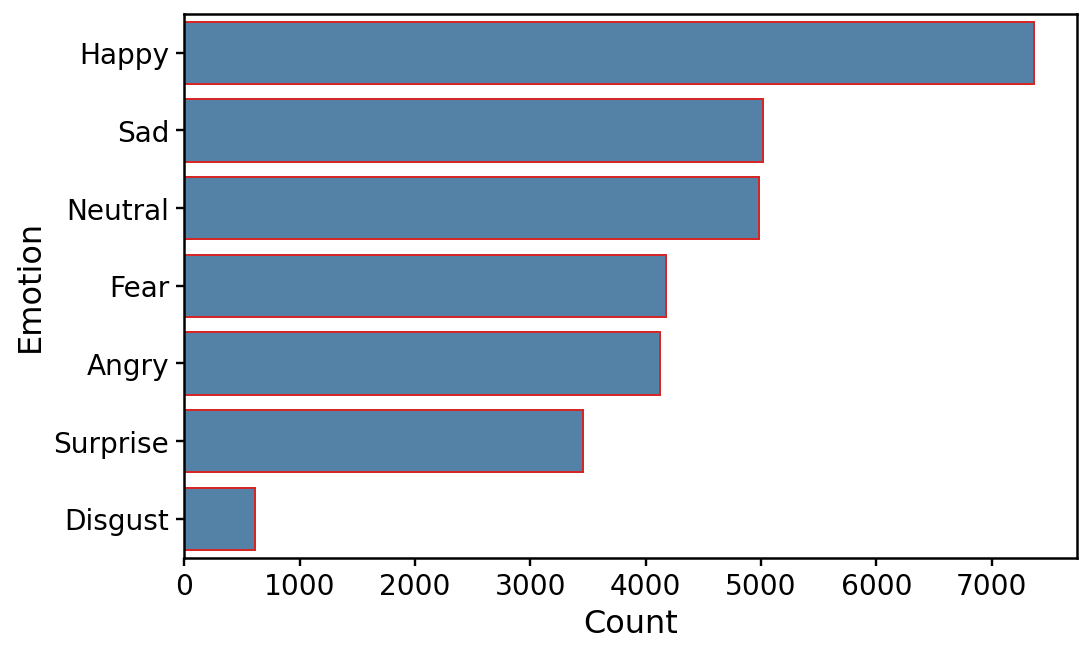

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(y='Emotion',
            x='Count',
            color='steelblue',
            edgecolor='tab:red',
            data=df)

plt.show()

Unfortunately, there is a significant imbalance in our data, with the ‘happy’ class being the most prevalent and the ‘disgust’ class being noticeably underrepresented.

<br>

## Image Augmentation

Image Data Augmentation is a technique used to expand the training dataset to improve the model's performance and ability to generalise. Data augmentation enables us to ‘augment’ the training images via a number of random transformations so that our model would never see twice the same image. This practice reduces overfitting, making data augmentation a regularisation technique.

For example, we can slightly shift, rotate, and resize every picture in the training set by various amounts. This practice forces the model to be more tolerant to variations in the position, orientation, and size of the objects in the pictures.

<br>

Data augmentation is supported in Keras via the `keras.preprocessing.image.ImageDataGenerator ` class. The following transformations will be applied to the images used for training:

- Image rotations via the `rotation_range` argument.
- Image shifts via the `width_shift_range` and `height_shift_range` arguments.
- Shearing transformations via the `shear_range` argument.
- Image zoom via the `zoom_range` argument.
- Image horizontal flips via the `horizontal_flip` argument.

The value of each argument denotes the maximum extent of each transformation. For example, setting `rotation_range` to `20` means that training images will be randomly rotated between 0 and 20 degrees. 

`rescale` is a value by which we will multiply the data before any other processing. Here, we will normalize our images between 0 and 1 by scaling with a 1/255 factor.
`fill_mode` is the strategy used for filling in newly created pixels.

Notice that validation images only require rescaling; since the model doesn’t get trained on them, there is no point in transforming them.



In [24]:
batch_size = 32

datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.20,
    height_shift_range=0.20,
    shear_range=0.20,
    zoom_range=0.20,
    fill_mode='nearest',
    horizontal_flip=True,
    rescale=1. / 255
)

datagen_validation = ImageDataGenerator(rescale=1. / 255)

The `ImageDataGenerator` class provides three different functions for loading the image dataset in memory and generating batches of augmented data. In this project, we will be using the `flow_from_directory()` method that takes a path of a directory and generates batches of augmented data.

In [25]:
train_generator = datagen_train.flow_from_directory(
    directory=base_path + 'train',
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(
    directory=base_path + 'validation',
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False)

Found 29748 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


<br>

## Creating the Model

Our model starts by stacking three blocks of layers sequentially. Each block consists of the following sequence of layers:
1.	Conv2D
2.	BatchNormalization
3.	Conv2D
4.	BatchNormalization
5.	MaxPooling2D
6.	Dropout

Next is the fully connected network, composed of one hidden dense layer and a dense output layer. Note that we must flatten its inputs since a dense network expects a 1D array of features for each instance.

In [26]:
model = Sequential(name='CNN_Model')

### Block #01
model.add(
    Conv2D(filters=64,
           kernel_size=(5, 5),
           input_shape=(img_width, img_height, img_depth),
           activation='elu',
           padding='same',
           kernel_initializer='he_normal',
           name='Conv2D_01'))
model.add(BatchNormalization(name='BatchNorm_01'))

model.add(
    Conv2D(filters=64,
           kernel_size=(5, 5),
           activation='elu',
           padding='same',
           kernel_initializer='he_normal',
           name='Conv2D_02'))
model.add(BatchNormalization(name='BatchNorm_02'))

model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPool2D_01'))
model.add(Dropout(0.4, name='Dropout_01'))


### Block #02
model.add(
    Conv2D(filters=128,
           kernel_size=(3, 3),
           activation='elu',
           padding='same',
           kernel_initializer='he_normal',
           name='Conv2D_03'))
model.add(BatchNormalization(name='BatchNorm_03'))

model.add(
    Conv2D(filters=128,
           kernel_size=(3, 3),
           activation='elu',
           padding='same',
           kernel_initializer='he_normal',
           name='Conv2D_04'))
model.add(BatchNormalization(name='BatchNorm_04'))

model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPool2D_02'))
model.add(Dropout(0.4, name='Dropout_02'))


### Block #03
model.add(
    Conv2D(filters=256,
           kernel_size=(3, 3),
           activation='elu',
           padding='same',
           kernel_initializer='he_normal',
           name='Conv2D_05'))
model.add(BatchNormalization(name='BatchNorm_05'))

model.add(
    Conv2D(filters=256,
           kernel_size=(3, 3),
           activation='elu',
           padding='same',
           kernel_initializer='he_normal',
           name='Conv2D_06'))
model.add(BatchNormalization(name='BatchNorm_06'))

model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPool2D_03'))
model.add(Dropout(0.4, name='dropout_03'))


### Dense  Layer
model.add(Flatten(name='flatten'))

model.add(
    Dense(128,
          activation='elu',
          kernel_initializer='he_normal',
          name='Dense_01'))
model.add(BatchNormalization(name='BatchNorm_07'))
model.add(Dropout(0.4, name='Dropout_04'))


### Output Layer
model.add(Dense(num_classes, activation='softmax', name='Output'))

model.summary()

Model: "CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_01 (Conv2D)          (None, 48, 48, 64)        1664      
                                                                 
 BatchNorm_01 (BatchNormaliz  (None, 48, 48, 64)       256       
 ation)                                                          
                                                                 
 Conv2D_02 (Conv2D)          (None, 48, 48, 64)        102464    
                                                                 
 BatchNorm_02 (BatchNormaliz  (None, 48, 48, 64)       256       
 ation)                                                          
                                                                 
 MaxPool2D_01 (MaxPooling2D)  (None, 24, 24, 64)       0         
                                                                 
 Dropout_01 (Dropout)        (None, 24, 24, 64)        0 

The number of filters grows as we climb up the neural network towards the output layer: it is initially 64, then 128, then 256. As we read in [this excellent book](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), it makes sense for it to grow since the number of low-level features is often fairly low (e.g., small circles, horizontal lines, etc.), but there are many different ways to combine them into higher-level features. It is a common practice to double the number of filters after each pooling layer: since a pooling layer divides each spatial dimension by a factor of 2, we can afford to double the number of feature maps in the next layer, without fear of exploding the number of parameters, memory usage, or computational load.

<br>

## Compiling the Model

After creating a model, we must call its `compile()` method to specify the loss function and the optimizer. Optionally, we can also specify a list of extra metrics to compute during training and evaluation.

Specifically, we will use:

- `categorical_crossentropy`, which computes the cross-entropy loss between the labels and predictions. This loss function is ideal when there are two or more label classes. We expect labels to be provided in an one_hot representation.
- `Adam` to implement Adam optimisation. Adam can be viewed as a combination of two other optimisers: momentum and RMSprop. Just like Momentum optimization it keeps track of an exponentially decaying average of past gradients, and just like RMSProp it keeps track of an exponentially decaying average of past squared gradients.
- 'accuracy' as the only metric to be evaluated.

In [27]:
# optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, name='Adam')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

<br>

## Callbacks

The `fit()` method accepts a callbacks argument that lets you specify a list of objects that Keras will call during training at the start and end of training, at the start and end of each epoch and even before and after processing each batch. 

First, we will add the `EarlyStopping` callback to implement early stopping. It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the `patience `argument), and it will roll back to the best model (`restore_best_weights=True `).

For performance scheduling, we will use the `ReduceLROnPlateau` callback. Simply put, performance scheduling measures the validation error every N steps and reduces the learning rate by a factor of λ when the error stops dropping. For example, if you pass the following callback to the `fit()` method, it will multiply the learning rate by 0.5 whenever the best validation loss does not improve for 7 consecutive epochs.

In [28]:
early_stopping_cb = EarlyStopping(monitor='val_accuracy',
                                  min_delta=0.0005,
                                  patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

lr_scheduler_cb = ReduceLROnPlateau(monitor='val_accuracy',
                                    factor=0.5,
                                    patience=7,
                                    verbose=1,
                                    min_lr=1e-7)

callbacks = [early_stopping_cb, lr_scheduler_cb]

<br>

## Training the Model

Now the model is ready to be trained. For this we simply need to call its `fit()`
method. Data augmentation is implemented if the first argument provided is a generator object that will yield batches of inputs and targets indefinitely. Because the data is being generated endlessly, the model needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, the fitting process will go to the next epoch. In our case, `steps_per_epoch` is set as the total number of training images divided by the batch size.

In [29]:
batch_size = 32
epochs = 100

history = model.fit(
    x=train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=callbacks)

Epoch 1/100
929/929 [==============================] - 66s 64ms/step - loss: 2.0071 - accuracy: 0.2212 - val_loss: 1.7111 - val_accuracy: 0.3179 - lr: 0.0010
Epoch 2/100
929/929 [==============================] - 54s 58ms/step - loss: 1.7440 - accuracy: 0.2985 - val_loss: 1.7025 - val_accuracy: 0.3564 - lr: 0.0010
Epoch 3/100
929/929 [==============================] - 52s 56ms/step - loss: 1.5707 - accuracy: 0.3887 - val_loss: 1.3500 - val_accuracy: 0.4902 - lr: 0.0010
Epoch 4/100
929/929 [==============================] - 53s 57ms/step - loss: 1.4378 - accuracy: 0.4470 - val_loss: 1.2840 - val_accuracy: 0.5142 - lr: 0.0010
Epoch 5/100
929/929 [==============================] - 52s 56ms/step - loss: 1.3627 - accuracy: 0.4771 - val_loss: 1.2254 - val_accuracy: 0.5341 - lr: 0.0010
Epoch 6/100
929/929 [==============================] - 52s 56ms/step - loss: 1.3073 - accuracy: 0.5033 - val_loss: 1.1588 - val_accuracy: 0.5571 - lr: 0.0010
Epoch 7/100
929/929 [==============================]

Training is complete. We can save the trained model using the `save()` method. 

In [30]:
model.save('model.h5')

Keras will save both the model’s architecture (including every layer’s hyperparameters) and the value of all the model parameters for every layer (e.g., connection weights and biases), using the HDF5 format. It also saves the optimizer (including its hyperparameters and any state it may have) [Source](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/).

Loading the model is just as easy:

In [31]:
loaded_model = keras.models.load_model('/content/model.h5')

<br>

## Assessing Performance

### Learning Curves

In Deep Learning, learning curves display a model’s loss and extra metrics (such as accuracy) measured at the end of each epoch on the training set and on the validation set (if any). Learning curves are a widely used diagnostic tool as they help us diagnose common problems with training neural networks, such as underfiting or overfitting the data.

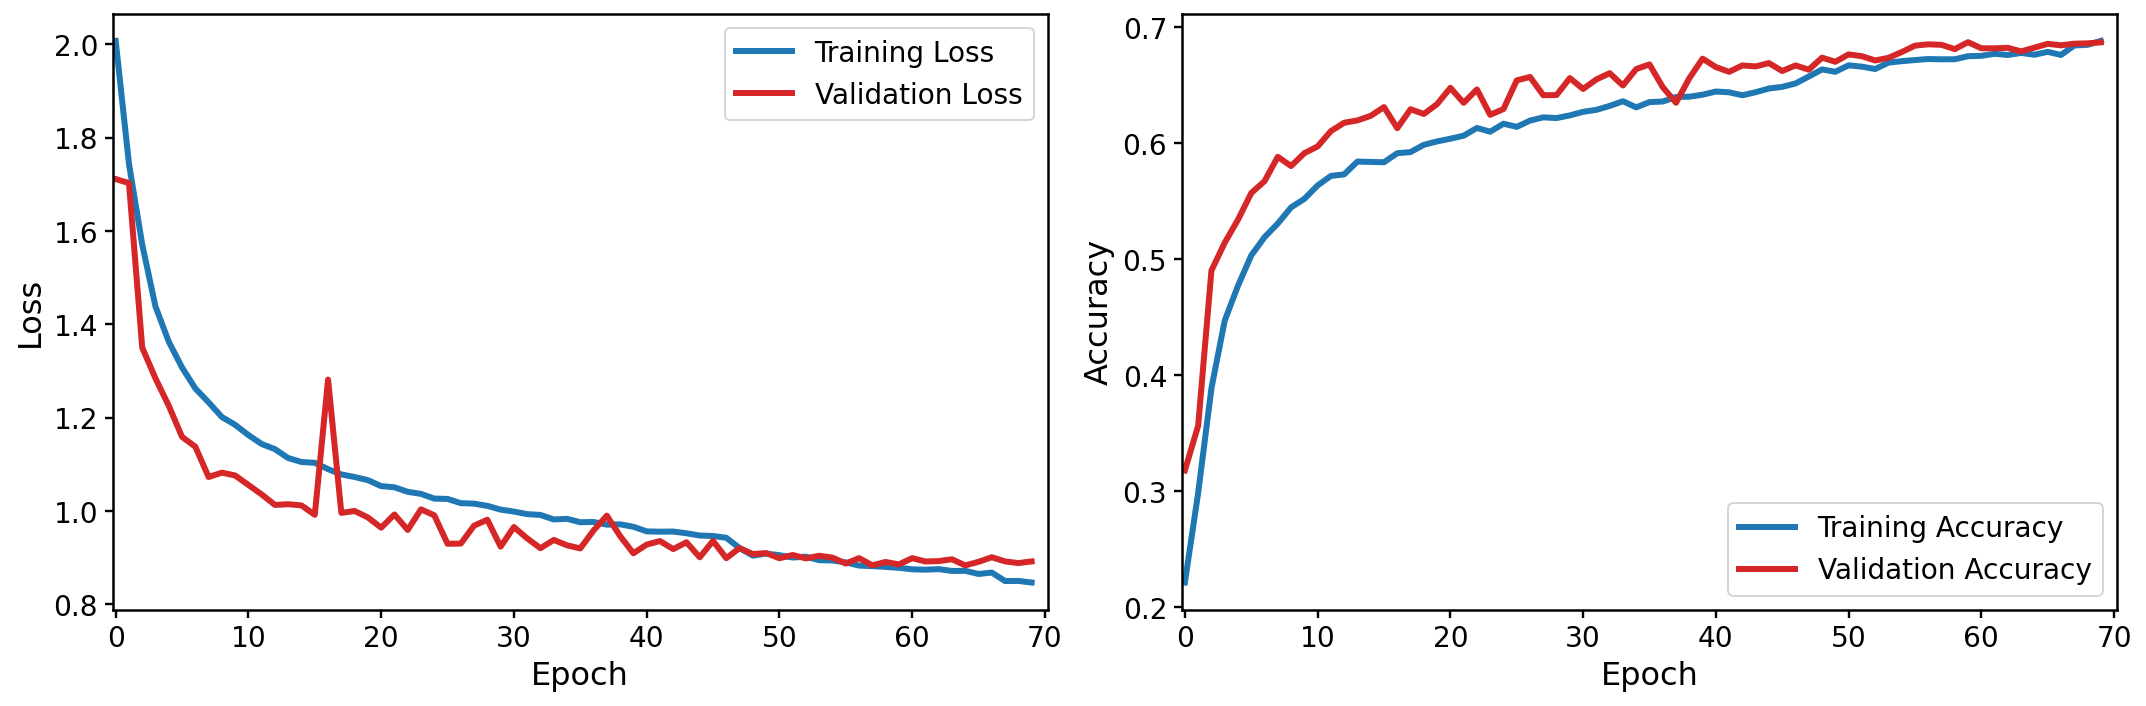

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')

for ax in [ax1, ax2]:
    ax.set_xlabel('Epoch')
    ax.set_xlim(left=-0.2, right=len(history.history['loss']) + 0.2)
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

The two figures demonstrate that both the training and validation loss steadily decrease during training, while the training and validation accuracy increase. More importantly, the validation curves are quite close to the training curves at the end of training, which indicates that there is **not** too much overfitting.

<br>

### Making Predictions and Confusion Matrix

The next step is using the model to make predictions on new images. Since we don’t have actual new images, we will use the (augmented) validation data.

For this purpose, we call the model’s `predict()` method using the generator object as the `x` argument.


In [33]:
predictions = loaded_model.predict(x=validation_generator)
class_labels = validation_generator.class_indices.keys()

 For each instance, the model estimates one probability per class. For example, the model is 89.2% certain that the first image belongs to the first class (i.e. ‘angry’).

In [34]:
predictions[0]

array([9.0760785e-01, 2.2554253e-03, 3.8354870e-02, 1.2779755e-04,
       6.4000878e-03, 4.0934067e-02, 4.3199277e-03], dtype=float32)

We can extract the most probable class by using NumPy’s ` argmax` function. We can also extract the actual labels and compute a confusion matrix to assess our model’s performance across all classes.

In [35]:
y_pred = [np.argmax(prediction) for prediction in predictions]
y_test = validation_generator.classes

cm = confusion_matrix(y_test, y_pred, normalize='true')

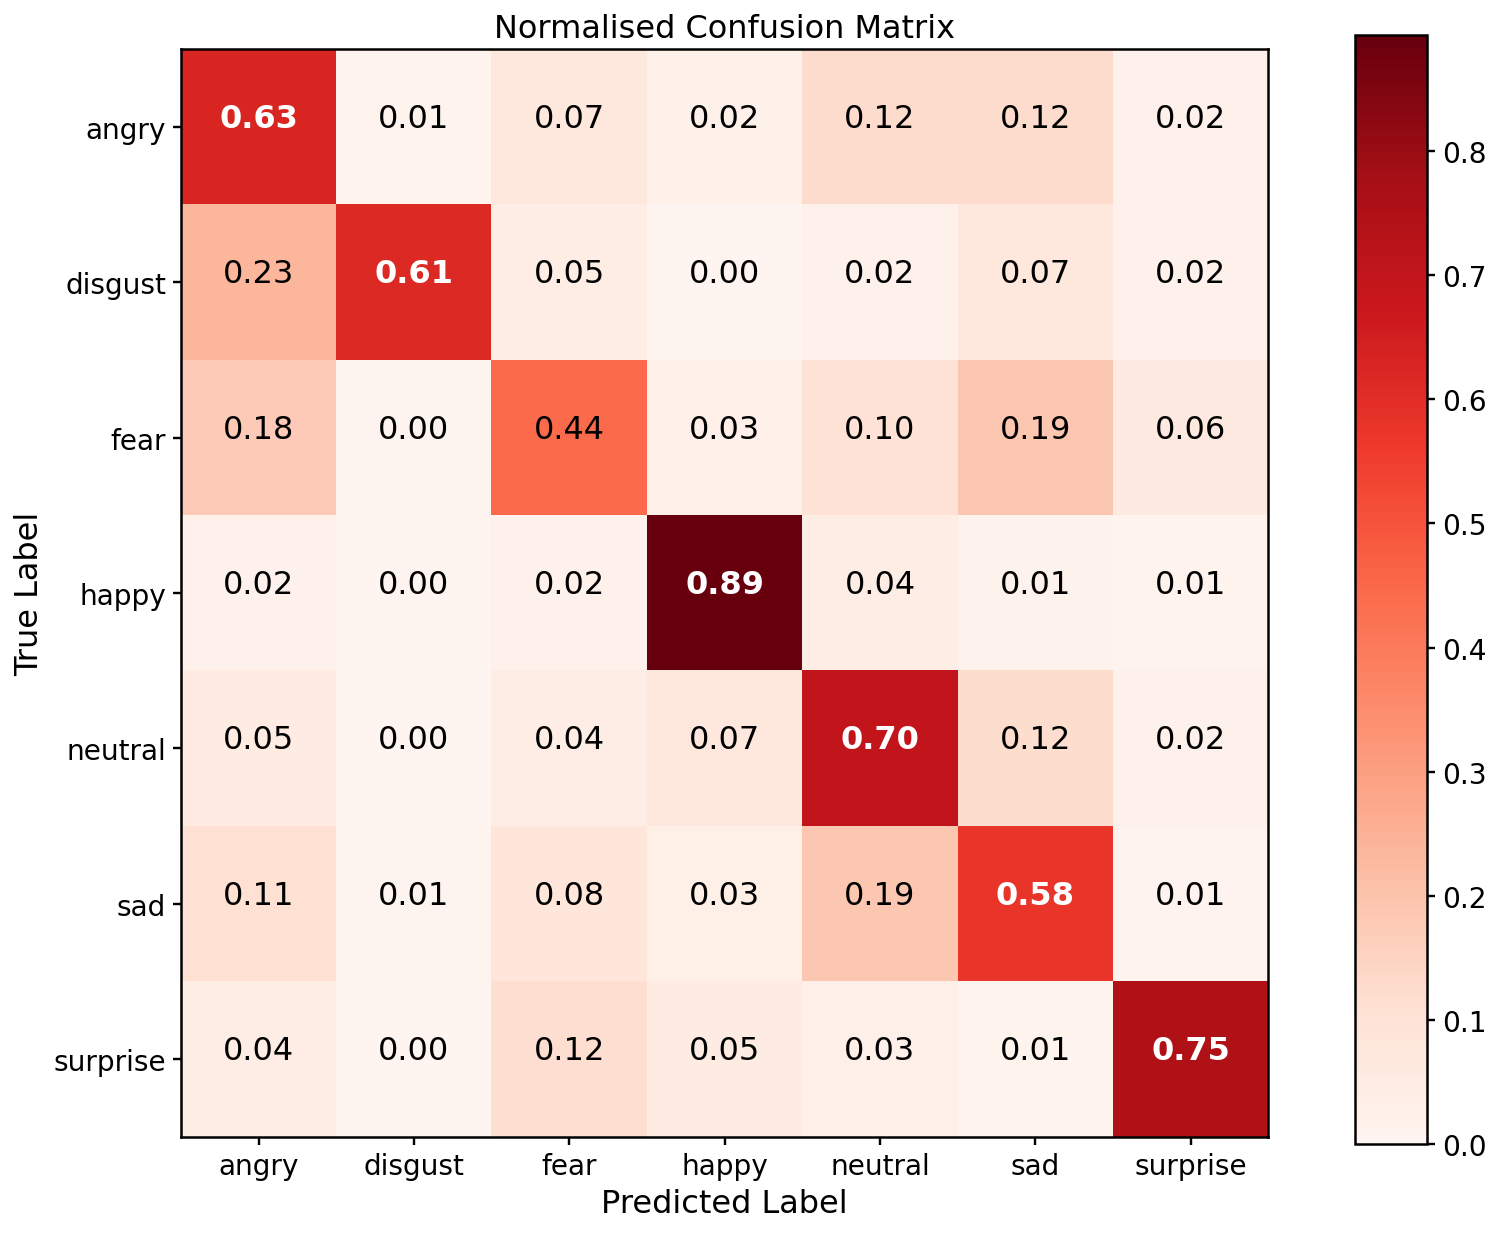

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(cm, interpolation='nearest', cmap='Reds')

ax.set(title='Normalised Confusion Matrix',
       xlabel='Predicted Label',
       ylabel='True Label')

tick_marks = np.arange(len(class_labels))
ax.set_xticks(tick_marks)
ax.set_xticklabels(class_labels, rotation=0)
ax.set_yticks(tick_marks)
ax.set_yticklabels(class_labels)

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(x=j,
             y=i,
             s=format(cm[i, j], '.2f'),
             fontsize=16,
             ha='center',
             color='w' if cm[i, j] > thresh else 'k',
             weight='bold' if cm[i, j] > thresh else 'normal')

cax = plt.axes([0.95, 0.12, 0.05, 0.77])
plt.colorbar(mappable=im, cax=cax)

plt.show()

In summary, 

- Our model exhibits the best performance when classifying images of the happy class (89% accuracy). This observation doesn’t come as a surprise, as `happy` is the most prevalent class in the dataset.
- Contrary, the worst performance is observed for the fear class (44% acc.) as two out of three images in the class get misclassified. 21% of all images get misclassified as sad, while 18% get misclassified as fear.
- The model displays good/moderate performance for the remaining classes.

<br>

It is also worth checking some examples of misclassified images. This will help us understand the limitation of our model due to data quality.

<br>

### Wrongly Classified Images

It is also worth checking some examples of misclassified images. This will help us understand the limitation of our model due to data quality and wrong labelling.

In [37]:
def predict_single_img(emotion, file_name):
    img = load_img(path=base_path + f'validation/{emotion}/{file_name}',
                   target_size=(img_width, img_height))

    img = img_to_array(img) / 255
    img_tensor = tf.image.rgb_to_grayscale(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    class_preds = loaded_model.predict(img_tensor)

    return img, class_preds

In [38]:
def plot_wrong_preds(emotion):
    nrows, ncols = 2, 5
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 7))
    ax = ax.flatten()

    path = base_path + f'validation/{emotion}'
    file_names = os.listdir(path)

    index = 0
    for file_name in file_names:
        img, class_preds = predict_single_img(emotion, file_name)
        label = list(class_labels)[class_preds.argmax()]

        if label != emotion:
            ax[index].imshow(img)
            ax[index].text(x=23, y=-2, s=f"Label: {emotion}", fontsize=11, c='g', ha='right')
            ax[index].text(x=22, y=-2, s=" | ", fontsize=16, color='k')
            ax[index].text(x=25.6, y=-2, s=f"Pred.: {label}", fontsize=11, c='r', ha='left')

            ax[index].axis('off')
            index += 1

        if index == nrows * ncols: break

    plt.tight_layout()

<br>

#### Wrongly Classified `Neutral` Images

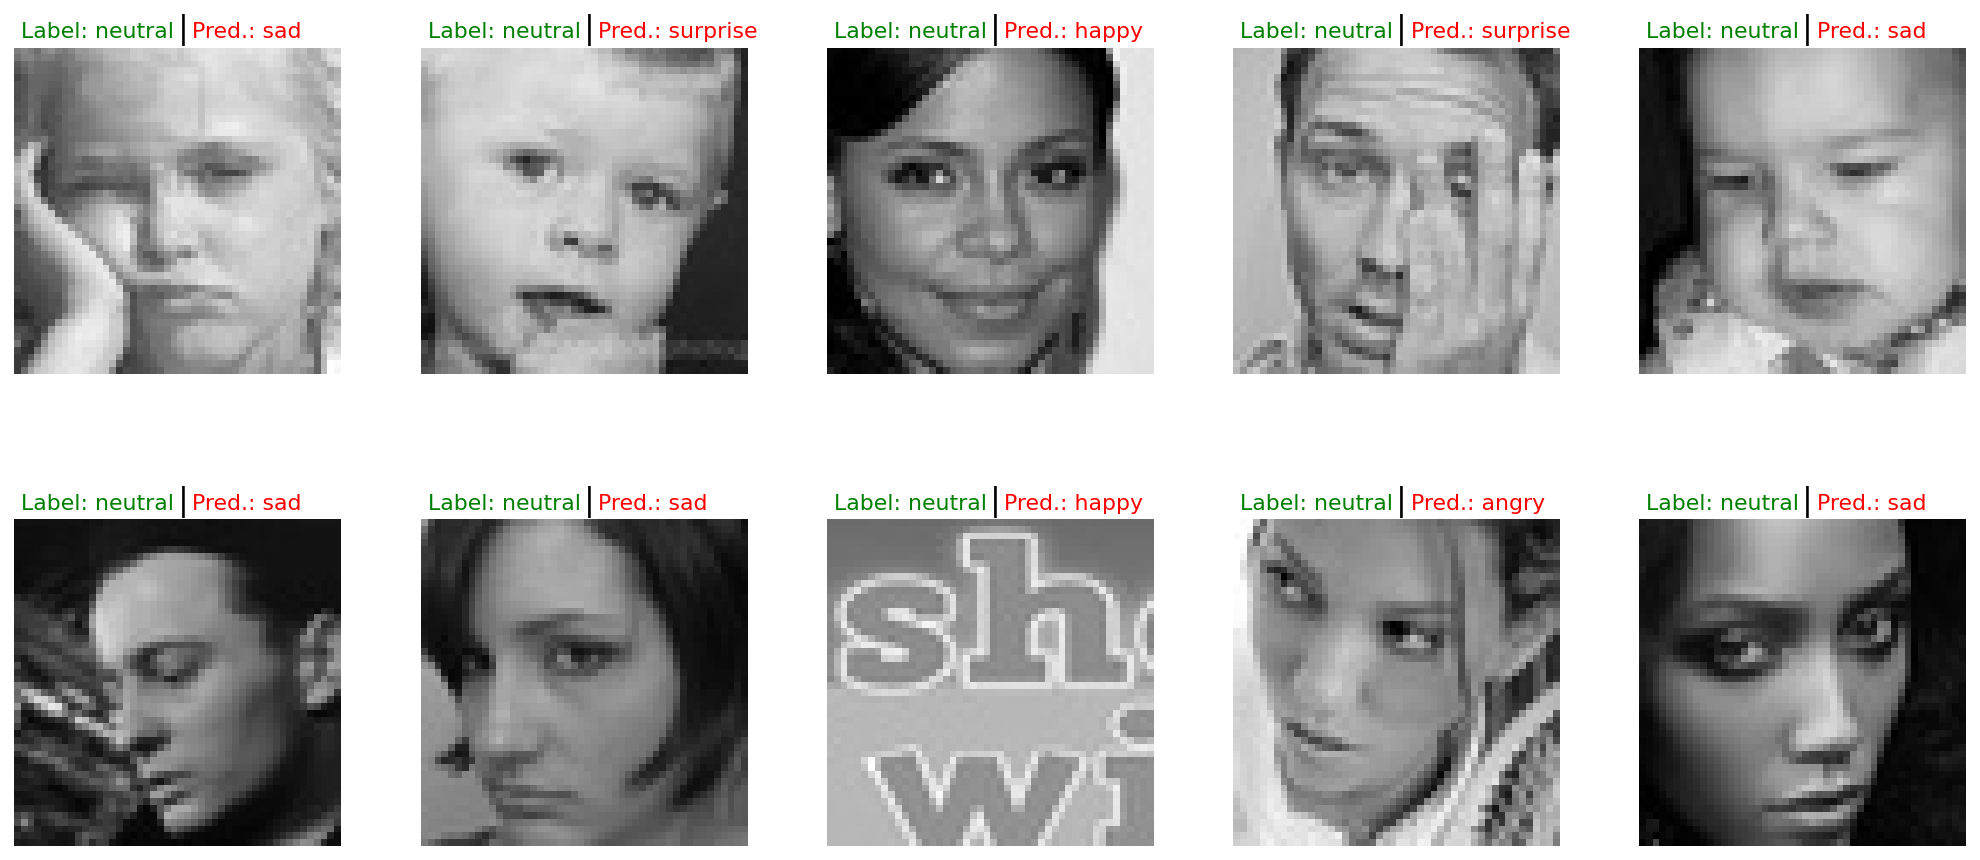

In [39]:
plot_wrong_preds('neutral')

<br>

#### Wrongly Classified `Sad` Images

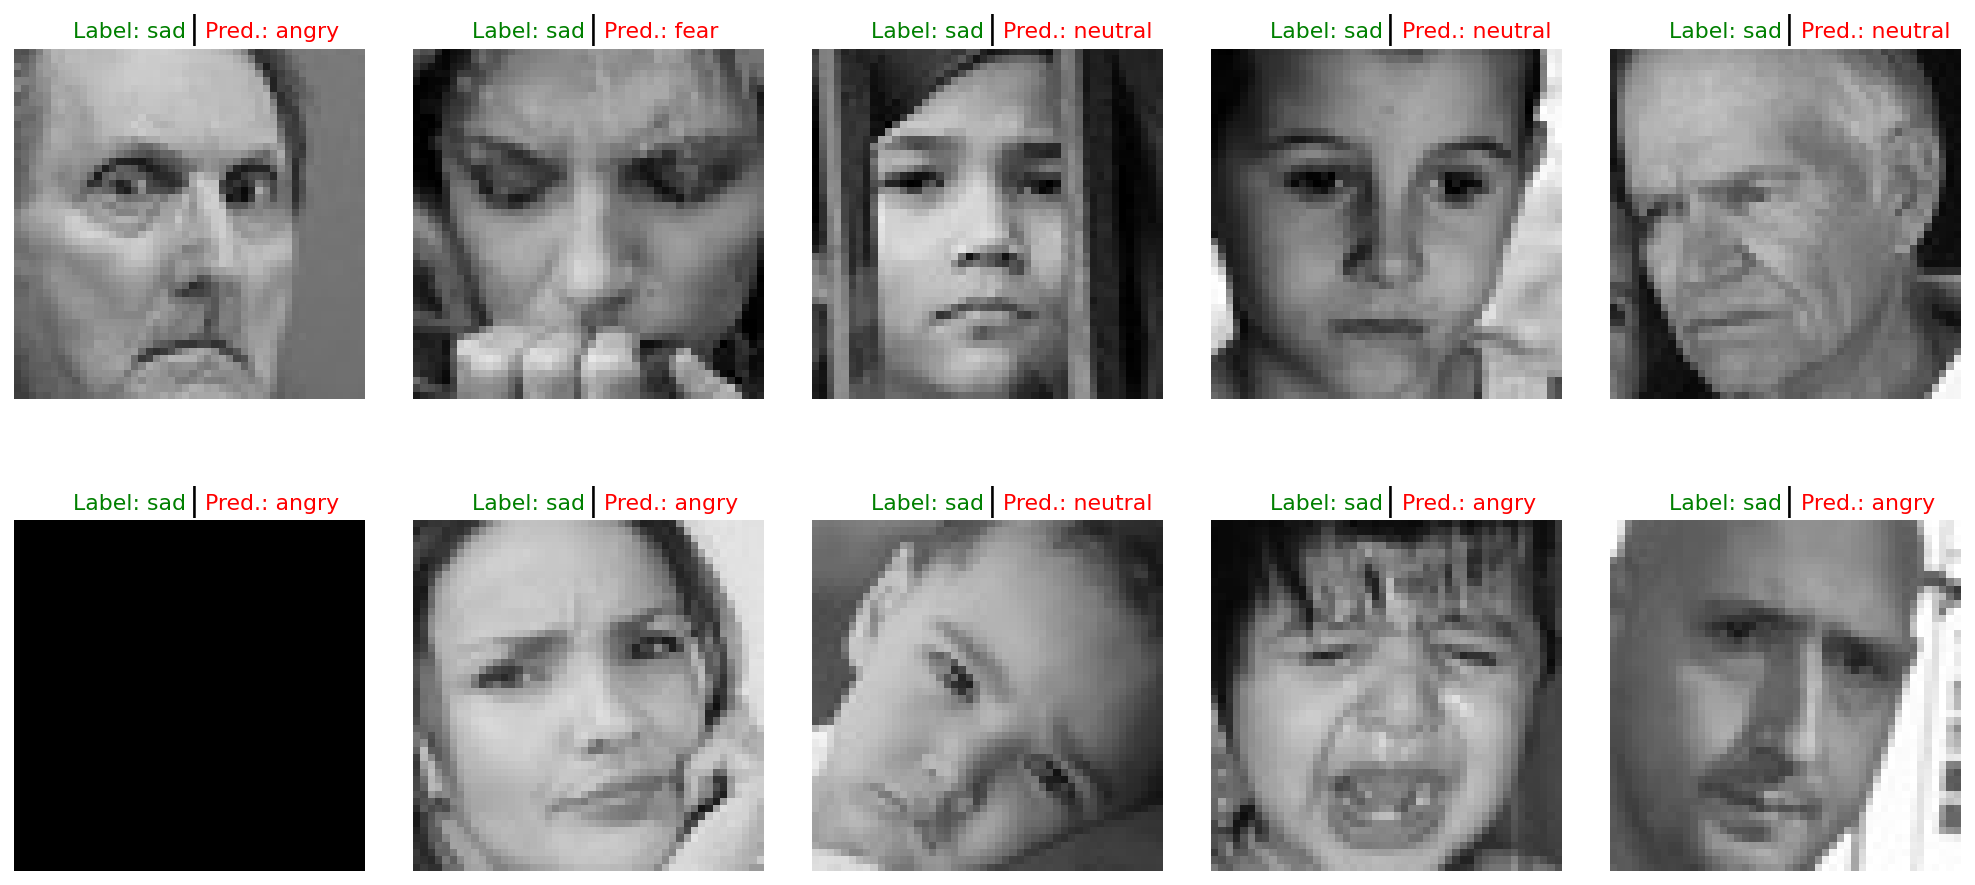

In [40]:
plot_wrong_preds('sad')

As you can see, even humans can get confused with some of those images. Additionally, classifying human emotion can be highly subjective, and different people might label images differently. These factors can negatively affect our model’s performance and limit its ability to predict some images accurately.

<br>

## Conclusions

In summary, we used Python’s Keras library to create, train, and evaluate a Deep Learning CNN model that predicts human emotion. The model can classify images into seven different emotions (angry, disgust, fear, happy, neutral, sad, surprise) with an overall (validation) accuracy of approximately equal to 69%.